# Latent features

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from warofwords import Dataset
from warofwords import TrainedWarOfWordsLatent

from warofwords.plotting import sigconf_settings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

LEG = 8
DATA = 'all_features'
FEAT = 'latent-text'
BASE = '/Users/kristof/GitHub/parl'

## Load data

In [5]:
dossier2title = dict()
with open(f'{BASE}/data/data/helpers/ep{LEG}-dossier2title.json', 'r') as f:
    for l in f.readlines():
        d = json.loads(l)
        for k, v in d.items():
            dossier2title[k.replace('_', '-')] = v

In [24]:
model = TrainedWarOfWordsLatent.load(f'{BASE}/public/war-of-words-2/2-training/trained-models/ep{LEG}-{DATA}-{FEAT}.predict')
vec = model._vec
parameters = model.parameters
features = parameters._features

In [21]:
meps = parameters._features.get_group('mep')
doss = parameters._features.get_group('dossier')

## PCA

In [31]:
def get_dossiers(features, vec):
    """Get top (which='top') or bottom (which='bottom') dossiers."""
    doss = features.get_group('dossier')
    return [features.get_name(d) for d in doss], vec[doss]

In [36]:
doss_refs, vec_y = get_dossiers(features, vec)

In [37]:
n_dims = 10
pca = PCA(n_components=n_dims)
pca.fit(vec_y)

PCA(n_components=10)

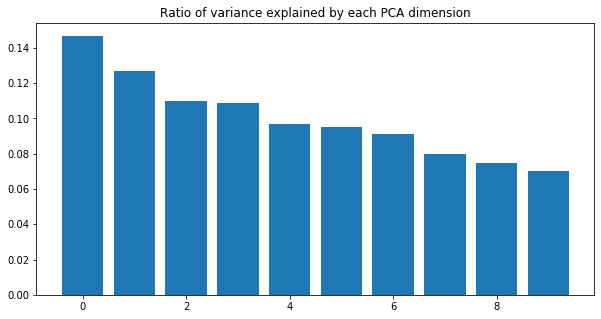

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(n_dims), pca.explained_variance_ratio_)
ax.set_title("Ratio of variance explained by each PCA dimension")
plt.show()

In [39]:
def plot_pca(pca, vec_y, doss_refs, dim, which, n=10):
    """Order: which='top' or which='bottom'"""
    coords = pca.transform(vec_y)
    # Sorted according to coordinate along one PCA dimension.
    idx = np.argsort(coords[:, dim])
    # Get order.
    if which == 'top':
         rank = idx[::-1][:n]
    elif which == 'bottom':
         rank = idx[:n][::-1]
    # Plot top-n.
    for i in rank:
        ref = doss_refs[i]
        title = dossier2title[ref]
        print(f'{coords[i, dim]:+.3f} {ref:<10} {title}\n')

In [40]:
plot_pca(pca, vec_y, doss_refs, dim=0, which='top')

+2.135 A8-0198-2017 Extension of the duration of the European Fund for Strategic Investments as well as the introduction of technical enhancements for that Fund and the European Investment Advisory Hub

+1.885 A8-0238-2016 Prospectus to be published when securities are offered to the public or admitted to trading

+1.848 A8-0011-2016 Activities and supervision of institutions for occupational retirement provision (recast)

+1.530 A8-0008-2017 Establishing a Union programme to support specific activities enhancing the involvement of consumers and other financial services end-users in Union policy making in the field of financial services for the period of 2017-2020

+1.314 A8-0139-2015 European Fund for Strategic Investments

+1.174 A8-0318-2017 European Electronic Communications Code (Recast)

+1.016 A8-0296-2015 Proposal for a regulation of the European Parliament and of the Council amending the Statute of the Court of Justice of the European Union by increasing the number of judges a

In [41]:
plot_pca(pca, vec_y, doss_refs, dim=0, which='bottom')

-0.742 EMPL-AD(2017)601220 Preventive restructuring frameworks, second chance and measures to increase the efficiency of restructuring, insolvency and discharge procedures

-0.769 LIBE-AD(2016)582370 Contracts for the supply of digital content

-0.780 A8-0438-2018 Re-use of public sector information (recast)

-0.786 A8-0322-2017 European Travel Information and Authorisation System (ETIAS) and amending Regulations (EU) No 515/2014, (EU) 2016/399 and (EU) 2016/1624

-0.801 AFET-AD(2016)578500 Establishing an EU common list of safe countries of origin for the purposes of common procedures for granting and withdrawing international protection

-0.814 BUDG-AD(2018)612357 Establishing the European Defence Industrial Development Programme aiming at supporting the competitiveness and innovative capacity of the EU defence industry

-0.909 REGI-AD(2019)629571 Establishing the Instrument for Pre-accession Assistance (IPA III)

-0.922 REGI-AD(2018)627807 Protection of the Union's budget in case of

## t-SNE

In [114]:
def plot_tsne(pca, vec_y, perplexity, seed=0, n=10):
    coords = pca.transform(vec_y)
    dims = [0, 1]
    # Get dossiers (avoid double counting).
    idx = set()
    for dim in dims:
        idx.update(np.argsort(coords[:,dim])[::-1][:n])
        idx.update(np.argsort(coords[:,dim])[:n])
    idx = np.array(list(idx))
    print(f'Keeping {len(idx)} dossiers for projection')
    
    # Compute t-SNE
    tsne = TSNE(perplexity=perplexity, random_state=seed)
    embed = tsne.fit_transform(vec_y[idx,:])
    plt.scatter(embed[:, 0],embed[:,1])
    plt.show()
    
    return embed, coords, idx


def display_dossiers(embed, coords, idx, doss_refs, x_lo, x_hi, y_lo, y_hi):
    for i, (x, y) in zip(idx, embed):
        cond_x = (x < x_hi) and (x > x_lo)
        cond_y = (y < y_hi) and (y > y_lo)
        if cond_x and cond_y:
            ref = doss_refs[i]
            title = dossier2title[ref]
            print(f'{x:+.0f} {y:+.0f} {ref:<10} {title}\n')

Seed: 29
Keeping 37 dossiers for projection


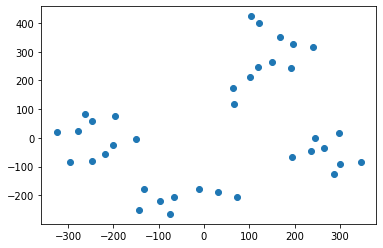

In [100]:
print(f'Seed: {seed}')
embed, coords, idx = plot_tsne(pca, vec_y, perplexity=3, seed=4, n=10)

In [115]:
# Top.
x_lo, x_hi = 0, 300
y_lo, y_hi = 50, 500
display_dossiers(embed, coords, idx, doss_refs, x_lo, x_hi, y_lo, y_hi)

+121 +398 A8-0295-2018 Prudential supervision of investment firms

+65 +175 EMPL-AD(2017)601220 Preventive restructuring frameworks, second chance and measures to increase the efficiency of restructuring, insolvency and discharge procedures

+196 +326 A8-0421-2018 Establishing the "Fiscalis" programme for cooperation in the field of taxation

+102 +213 LIBE-AD(2016)582370 Contracts for the supply of digital content

+149 +265 AGRI-AD(2015)552126 Trade in seal products

+67 +116 A8-0322-2017 European Travel Information and Authorisation System (ETIAS) and amending Regulations (EU) No 515/2014, (EU) 2016/399 and (EU) 2016/1624

+169 +352 A8-0270-2015 Reduction of pollutant emissions from road vehicles

+118 +246 TRAN-AD(2018)627011 Establishing the Digital Europe programme for the period 2021-2027

+241 +315 A8-0139-2015 European Fund for Strategic Investments

+193 +245 A8-0482-2018 Establishing the InvestEU Programme

+104 +423 A8-0011-2019 European Union macro-prudential oversight of 

In [117]:
# Right.
x_lo, x_hi = 150, 400
y_lo, y_hi = -200, 50
display_dossiers(embed, coords, idx, doss_refs, x_lo, x_hi, y_lo, y_hi)

+297 +18 TRAN-AD(2018)623885 Establishing a European Labour Authority

+288 -125 A8-0238-2016 Prospectus to be published when securities are offered to the public or admitted to trading

+265 -36 A8-0296-2015 Proposal for a regulation of the European Parliament and of the Council amending the Statute of the Court of Justice of the European Union by increasing the number of judges at the General Court

+301 -90 A8-0008-2017 Establishing a Union programme to support specific activities enhancing the involvement of consumers and other financial services end-users in Union policy making in the field of financial services for the period of 2017-2020

+246 -0 A8-0316-2017 Union Resettlement Framework

+347 -84 A8-0198-2017 Extension of the duration of the European Fund for Strategic Investments as well as the introduction of technical enhancements for that Fund and the European Investment Advisory Hub

+236 -44 A8-0135-2017 EU guarantee to the European Investment Bank against losses under fi

In [134]:
# Bottom.
x_lo, x_hi = -200, 100
y_lo, y_hi = -300, -150
display_dossiers(embed, coords, idx, doss_refs, x_lo, x_hi, y_lo, y_hi)

-133 -177 BUDG-AD(2018)612357 Establishing the European Defence Industrial Development Programme aiming at supporting the competitiveness and innovative capacity of the EU defence industry

+31 -189 A8-0412-2018 Establishing the European Defence Fund

-75 -265 REGI-AD(2018)627807 Protection of the Union's budget in case of generalised deficiencies as regards the rule of law in the Member States

+72 -204 A8-0037-2018 Establishing the European Defence Industrial Development Programme aiming at supporting the competitiveness and innovative capacity of the EU defence industry

-12 -179 A8-0064-2017 Amendment to Directive 2004/37/EC on the protection of workers from the risks related to exposure to carcinogens or mutagens at work

-143 -249 A8-0057-2018 Proposal for a Directive of the European Parliament and of the Council to empower the competition authorities of the Member States to be more effective enforcers and to ensure the proper functioning of the internal market

-97 -219 REGI-AD(

In [135]:
# Left.
x_lo, x_hi = -400, -100
y_lo, y_hi = -100, 100
display_dossiers(embed, coords, idx, doss_refs, x_lo, x_hi, y_lo, y_hi)

-196 +77 A8-0199-2015 Protection of undisclosed know-how and business information (trade secrets) against their unlawful acquisition, use and disclosure

-248 -79 AFET-AD(2018)616888 Establishing a framework for screening of foreign direct investments into the European Union

-264 +83 REGI-AD(2018)626678 Establishing the Connecting Europe Facility

-151 -4 A8-0305-2017 Body of European Regulators for Electronic Communications

-218 -55 A8-0461-2018 European Social Fund Plus (ESF+)

-325 +19 A8-0318-2017 European Electronic Communications Code (Recast)

-297 -85 A8-0438-2018 Re-use of public sector information (recast)

-247 +58 DEVE-AD(2018)626670 Unfair trading practices in business-to-business relationships in the food supply chain

-200 -26 CULT-AD(2018)627580 Establishing the InvestEU Programme

-278 +25 A8-0212-2017 Establishment of 'Eurodac' for the comparison of fingerprints for the effective application of Regulation (EU) No 604/2013, for identifying an illegally staying third-

In [140]:
clusters = {
   # Investment and Development.
    'id': 0,  
   # Social Security
    'ss': 1,  
   # Defense and Protection.
    'dp': 2,  
   # Economic Competitivity.
    'ce': 3,  
   # Others
    'ot': 4,  
}

ref2cluster = {
    # Top cluster: Investment and Development
    'A8-0295-2018': 'id', # Investment firms
    'EMPL-AD(2017)601220': 'id', # Discharge procedures, finance
    'A8-0421-2018': 'id', # Fiscalis programme
    'LIBE-AD(2016)582370': 'id', # Contracts for digital content
    'AGRI-AD(2015)552126': 'id', # Trade seal products
    'A8-0322-2017': 'ot', # Travel information system
    'A8-0270-2015': 'id', # Pollutant emmissions from road vehicles
    'TRAN-AD(2018)627011': 'id', # Digital europe programme
    'A8-0139-2015': 'id', # Fund for strategic investments
    'A8-0482-2018': 'id', # InvestEU
    'A8-0011-2019': 'id', # Oversight of financial system
     # Right cluster: Social Security
    'TRAN-AD(2018)623885': 'ss', # Labour authority
    'A8-0238-2016': 'ot', # Prospectus offered when securities offered to the public for trading
    'A8-0296-2015': 'ss', # Increasing number of judges at ECJ general court
    'A8-0008-2017': 'ss', # Involvement of consumers and end-users in financial services
    'A8-0316-2017': 'ss', # Union Resettlement Framework (safe and lawful treatment for refugees)
    'A8-0198-2017': 'ss', # Extension of European Fund for Strategic Investments
    'A8-0135-2017': 'ss', # Limitation of risk of EIB for investments outside EU
    'A8-0011-2016': 'ss', # Supervision of institution for retirement provision
    # Bottom cluster: Defense and Protection
    'BUDG-AD(2018)612357': 'dp', # Support of defense industry
    'A8-0412-2018': 'dp', # European Defense Fund
    'REGI-AD(2018)627807': 'dp', # Protection of budget in case of deficiencies
    'A8-0037-2018': 'dp', # Support of defense industry
    'A8-0064-2017': 'dp', # Protection of workers from carinogens
    'A8-0057-2018': 'dp', # Enhance competition authorities for better internal market
    'REGI-AD(2019)629571': 'dp', # Instrument for Pre-accession Assistance (IPA)
    'AFET-AD(2016)578500': 'dp', # Safe countries and international protection
    # Left cluster: Economic Competitiveness
    'A8-0199-2015': 'ec', # Protection of trade secrets
    'AFET-AD(2018)616888': 'ec', # Screening foreign direct investments
    'REGI-AD(2018)626678': 'ec', # Connecting Europe Facility
    'A8-0305-2017': 'ec', # Electronic Communications
    'A8-0461-2018': 'ec', # Social Fund Plus
    'A8-0318-2017': 'ec', # Electronic Communications Code
    'A8-0438-2018': 'ec', # Re-use of public sector information
    'DEVE-AD(2018)626670': 'ec', # Unfair trading in B2B in food supply chain
    'A8-0212-2017': 'ot', # Eurodac: fingerprints to identify illegal third-country national
    'CULT-AD(2018)627580': 'ec', # InvestEU
}    

colors = {
    'dp': 'C3',
    'ec': 'C1',
    'ss': 'C2',
    'id': 'C0',
    'ot': 'lightgray',
}

markers = {
    'dp': 'X',
    'ec': 's',
    'ss': 'v',
    'id': 'o',
    'ot': '.',
}

labels = [
    r'Defense \& Protection',
    r'Investment \& Development',
    r'Social Security',
    r'Economic Competitiveness',
    r'Others'
]

Sigconf settings loaded!


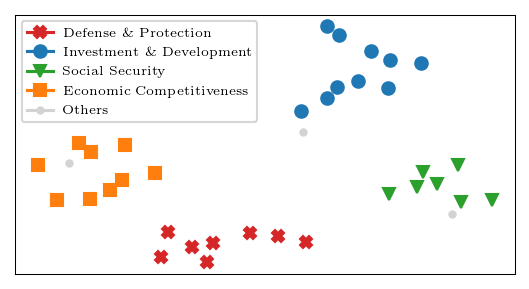

In [141]:
sigconf_settings()
fig, ax = plt.subplots(figsize=(3.6, 2.0))

lines = dict()

for i, (x, y) in zip(idx, embed):
    ref = doss_refs[i]
    cluster = ref2cluster[ref]
    line = ax.plot(x, y, color=colors[cluster], marker=markers[cluster])
    if cluster not in line:
        lines[cluster] = line[0]
    
handles = [lines['dp'],
           lines['id'],
           lines['ss'],
           lines['ec'],
           lines['ot']]



plt.legend(handles, labels,
           loc='upper left',
           frameon=True,
           fontsize='x-small',
#            bbox_to_anchor=(0.60,0.80)
          )
plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,        # tickcs on the left edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False, # labels along the bottom edge are off
    labelleft=False) # labels along the bottom edge are off
# plt.title('t-SNE visualization of latent feature y_i')
plt.tight_layout()
plt.savefig('figures/tsne.pdf', bbox_inches='tight')
plt.show()

### Generate t-SNE plots for visual inspection

In [ ]:
ps = [4, 4.5, 5]
ss = list(range(0, 20))
for p, s in product(ps, ss):
    print(p, s)
    embed, coords, _ = plot_tsne(pca, vec_y, perplexity=p, seed=s, n=10)




def get_dossiers(features, vec):
    """Get top dossiers and their latent features."""
    doss = features.get_group('dossier')
    vec = vec[doss]
    return [features.get_name(d) for d in doss], vec.numpy()


def main():
    # Load mapping to titles.
    dossier2title = dict()
    with open(f'{BASE}/scrp/data/ep{LEG}-dossier2title.json', 'r') as f:
        for l in f.readlines():
            d = json.loads(l)
            for k, v in d.items():
                dossier2title[k.replace('_', '-')] = v

    # Get all dossiers and their latent features.
    doss, vec_y = get_dossiers(features, vec)

In [ ]:
n_dims = 20
pca = PCA(n_components=n_dims)
pca.fit(vec_y)